<a href="https://colab.research.google.com/github/ssyss-513/MyColab/blob/main/5511_a1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 136.0/136.0 kB 3.8 MB/s eta 0:00:00


In [2]:
import random
import math
import pandas as pd
import matplotlib.pyplot as plt

# DEAP imports
from deap import base, creator, tools, algorithms
import deap.creator as deap_creator  # to allow deletion of pre-created classes


In [3]:
# ---------------------------
# Helper: safely (re)create DEAP creator classes
# ---------------------------
def reset_deap_creator(fitness_name="FitnessMin", ind_name="Individual"):
    for name in (fitness_name, ind_name):
        if hasattr(deap_creator, name):
            try:
                delattr(deap_creator, name)
            except Exception:
                pass

reset_deap_creator()


In [4]:
# ---------------------------
# Load VRP.csv
# ---------------------------
csv_path = "VRP.csv"
df = pd.read_csv(csv_path, dtype=str)

# Normalize and decide columns
if "NO" in df.columns and any(c.upper().find("CUST") >= 0 for c in df.columns if isinstance(c, str)):
    # try to map standard column names
    cols = {c.upper(): c for c in df.columns}
    col_type = None
    for candidate in ["CUST OR DEPOT", "TYPE", "CUST_OR_DEPOT", "CUST/DEPOT"]:
        if candidate in cols:
            col_type = cols[candidate]
            break
    if col_type is None:
        col_type = df.columns[0]
    col_no = cols.get("NO", df.columns[1] if len(df.columns) > 1 else df.columns[0])
    candidate_coords = [c for c in df.columns if any(x in c.upper() for x in ["X", "LONG", "COORD", "LAT", "Y"])]
    col_x = candidate_coords[0] if len(candidate_coords) >= 1 else df.columns[2]
    col_y = candidate_coords[1] if len(candidate_coords) >= 2 else df.columns[3]
    col_demand = next((c for c in df.columns if "DEMAND" in c.upper()), df.columns[-1])
    df = df.rename(columns={col_type: "TYPE", col_no: "NO", col_x: "XCOORD", col_y: "YCOORD", col_demand: "DEMAND"})
else:
    # fallback: no header
    df = pd.read_csv(csv_path, header=None)
    if df.shape[1] < 5:
        raise ValueError("VRP.csv seems to have fewer than 5 columns.")
    df = df.rename(columns={0: "TYPE", 1: "NO", 2: "XCOORD", 3: "YCOORD", 4: "DEMAND"})

# Convert dtypes
df["TYPE"] = df["TYPE"].astype(str).str.strip()
df["NO"] = df["NO"].astype(int)
df["XCOORD"] = pd.to_numeric(df["XCOORD"])
df["YCOORD"] = pd.to_numeric(df["YCOORD"])
df["DEMAND"] = pd.to_numeric(df["DEMAND"])


In [5]:
df.head(5)

,TYPE,NO,XCOORD,YCOORD,DEMAND,EFFICIENCY
0,DEPOT,0,20.0,20.0,0,0.0
1,DEPOT,1,80.0,20.0,0,0.0
2,DEPOT,2,50.0,50.0,0,0.0
3,DEPOT,3,20.0,80.0,0,0.0
4,DEPOT,4,80.0,80.0,0,0.0


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105 entries, 0 to 104
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   TYPE        105 non-null    object 
 1   NO          105 non-null    int64  
 2   XCOORD      105 non-null    float64
 3   YCOORD      105 non-null    float64
 4   DEMAND      105 non-null    int64  
 5   EFFICIENCY  105 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 5.1+ KB


In [7]:
# ---------------------------
# Build coordinates and demands dicts, identify depot and customers
# ---------------------------
if ((df["TYPE"].str.upper() == "DEPOT") & (df["NO"] == 0)).any():
    depot_row = df[(df["TYPE"].str.upper() == "DEPOT") & (df["NO"] == 0)].iloc[0]
else:
    depot_rows = df[df["TYPE"].str.upper() == "DEPOT"]
    if len(depot_rows) == 0:
        raise ValueError("No depot row found in VRP.csv")
    depot_row = depot_rows.iloc[0]

depot_coords = (float(depot_row["XCOORD"]), float(depot_row["YCOORD"]))
depot_no = int(depot_row["NO"])

customers_df = df[df["TYPE"].str.upper().str.contains("CUST|CUSTOMER", na=False)]
if customers_df.empty:
    customers_df = df[df["NO"] != depot_no]

customer_id_list = list(customers_df["NO"].astype(int).tolist())
idx_to_cust = customer_id_list[:]
cust_to_idx = {cust_id: i for i, cust_id in enumerate(idx_to_cust)}

coords = {}
demands = {}
for _, row in customers_df.iterrows():
    cid = int(row["NO"])
    coords[cid] = (float(row["XCOORD"]), float(row["YCOORD"]))
    demands[cid] = float(row["DEMAND"])
coords[depot_no] = depot_coords
demands[depot_no] = 0.0

CAPACITY = 200.0


In [8]:
# ---------------------------
# Utility: Euclidean distance
# ---------------------------
def distance(a, b):
    return math.hypot(a[0] - b[0], a[1] - b[1])


In [9]:
# ---------------------------
# DEAP setup
# ---------------------------
reset_deap_creator()
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()

n_customers = len(idx_to_cust)
if n_customers == 0:
    raise ValueError("No customers detected in VRP.csv.")

toolbox.register("indices", random.sample, range(n_customers), n_customers)
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.indices)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)


In [14]:
def eval_vrp_classical(individual):
    """
    Classical deterministic VRP fitness.
    Input:
      individual: list of indices in 0..n_customers-1 (uses idx_to_cust mapping)
    Returns:
      (total_cost,)  -- one-tuple for DEAP minimization
    Notes:
      - Uses global coords, demands, depot_no, CAPACITY
      - Penalizes capacity violation by adding large constant PENALTY
    """
    PENALTY = 1e7  # capacity violation penalty (tune as needed)
    total_dist = 0.0
    load = 0.0
    current = depot_no
    for idx in individual:
        cust = idx_to_cust[idx]
        total_dist += distance(coords[current], coords[cust])
        load += demands[cust]
        if load > CAPACITY + 1e-9:
            total_dist += PENALTY
        current = cust
    # return to depot
    total_dist += distance(coords[current], coords[depot_no])
    return (total_dist,)


In [15]:
import numpy as np

def sample_demand(original_mean):
    """
    Sample truncated normal demand:
      N(mean, 0.2*mean), truncated to positive integer (>=0)
    """
    mu = original_mean
    sigma = max(1e-9, 0.2 * original_mean)  # avoid zero
    # simple truncation at 0, sample until positive
    val = -1
    while val <= 0:
        val = np.random.normal(mu, sigma)
    return int(round(val))

def eval_vrp_stochastic_singleobj(individual, M=50, PENALTY=1e6):
    """
    Stochastic-demand single-objective fitness.
    - M: number of Monte Carlo demand realizations to average over
    - PENALTY: per-infeasible-run penalty added to distance
    Returns (score,) where smaller is better.
    """
    total_score = 0.0
    feasible_count = 0
    for _ in range(M):
        # sample demands for all customers (dict)
        sampled_demands = {cid: sample_demand(demands[cid]) for cid in demands if cid != depot_no}
        # run route
        total_dist = 0.0
        load = 0.0
        current = depot_no
        infeasible = False
        for idx in individual:
            cust = idx_to_cust[idx]
            total_dist += distance(coords[current], coords[cust])
            load += sampled_demands.get(cust, 0)
            if load > CAPACITY + 1e-9:
                infeasible = True
            current = cust
        total_dist += distance(coords[current], coords[depot_no])
        if infeasible:
            total_score += (total_dist + PENALTY)
        else:
            total_score += total_dist
            feasible_count += 1
    expected_score = total_score / M
    feasibility_rate = feasible_count / M

    return (expected_score,)

toolbox.register("evaluate", eval_vrp_stochastic_singleobj)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)

In [25]:
from sklearn.cluster import DBSCAN
import numpy as np

# 提取顾客坐标 (排除 depot)
X = np.array([[coords[cid][0], coords[cid][1]] for cid in customer_id_list])

# 运行 DBSCAN
db = DBSCAN(eps=13, min_samples=5).fit(X)   # eps: 半径阈值, min_samples: 最小邻居数

# 获取标签 (-1 表示噪声点)
labels = db.labels_

# 建立顾客ID -> 簇号的映射
cust_cluster = {cid: int(label) for cid, label in zip(customer_id_list, labels)}

print("Cluster labels:", set(labels))
print("Cluster mapping example:", list(cust_cluster.items())[:10])


Cluster labels: {np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4), np.int64(-1)}
Cluster mapping example: [(5, 0), (6, -1), (7, 1), (8, 0), (9, 0), (10, 2), (11, 3), (12, 0), (13, 0), (14, 0)]


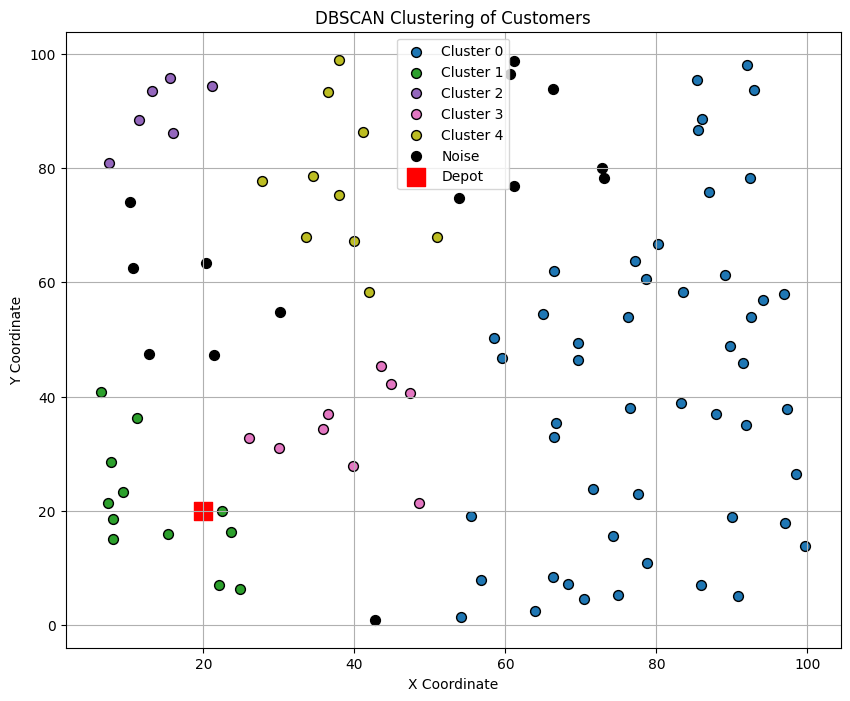

In [26]:
import matplotlib.pyplot as plt

# 提取顾客坐标
X = np.array([[coords[cid][0], coords[cid][1]] for cid in customer_id_list])

# DBSCAN 聚类标签
# labels = db.labels_  # 你已经有了

unique_labels = set(labels)
colors = [plt.cm.tab20(each) for each in np.linspace(0, 1, len(unique_labels))]

plt.figure(figsize=(10, 8))

for k, col in zip(unique_labels, colors):
    if k == -1:
        # 噪声点设为黑色
        col = [0, 0, 0, 1]

    class_mask = (labels == k)
    xy = X[class_mask]

    plt.scatter(xy[:, 0], xy[:, 1], c=[col], label=f"Cluster {k}" if k != -1 else "Noise", s=50, edgecolor='k')

# 标出 depot
plt.scatter(depot_coords[0], depot_coords[1], c='red', marker='s', s=150, label='Depot')

plt.xlabel("X Coordinate")
plt.ylabel("Y Coordinate")
plt.title("DBSCAN Clustering of Customers")
plt.legend()
plt.grid(True)
plt.show()


In [27]:
#Q3

def eval_vrp_with_clustering(individual, cust_cluster, PENALTY_PER_SEGMENT=1e6):
    """
    - cust_cluster: dict mapping real customer id -> cluster id
    - Penalize if a cluster is visited in multiple non-contiguous segments.
    Returns (cost,)
    """
    # compute total distance and record cluster visitation order
    total_dist = 0.0
    current = depot_no
    visit_clusters = []  # sequence of cluster ids as visited in order (for customers)
    for idx in individual:
        cust = idx_to_cust[idx]
        total_dist += distance(coords[current], coords[cust])
        visit_clusters.append(cust_cluster[cust])
        current = cust
    total_dist += distance(coords[current], coords[depot_no])

    # compute number of contiguous segments per cluster
    seen_segments = {}
    prev_cluster = None
    for cl in visit_clusters:
        if cl != prev_cluster:
            seen_segments[cl] = seen_segments.get(cl, 0) + 1
            prev_cluster = cl
    # extra segments = sum(segments - 1 for clusters with segments>1)
    extra_segments = sum(max(0, segs - 1) for segs in seen_segments.values())

    cost = total_dist + PENALTY_PER_SEGMENT * extra_segments
    return (cost,)


In [ ]:
#Q4-1

def eval_vrp_multi_weighted(individual, w=0.5):
    """
    Weighted single-objective: f = w * f1 - (1-w) * f2
    Return (f,) for DEAP minimization.
    Notes:
      - EFFICIENCY for each customer must be available: assume `efficiency[cid]` dict exists.
    """
    # compute f1 (total distance) and per-customer cumulative distance for f2
    total_dist = 0.0
    cumulative = 0.0
    current = depot_no
    f2_sum = 0.0
    for idx in individual:
        cust = idx_to_cust[idx]
        step = distance(coords[current], coords[cust])
        total_dist += step
        cumulative += step
        # efficiency score for cust:
        eff = efficiency.get(cust, 0.0)  # 默认 0.0，如果 VRP.csv 没有该列需要先构造
        f2_sum += (eff - cumulative)
        current = cust
    # back to depot
    step = distance(coords[current], coords[depot_no])
    total_dist += step

    f1 = total_dist
    f2 = f2_sum
    # weighted objective: minimize f = w*f1 - (1-w)*f2  (since we want maximize f2)
    f = w * f1 - (1.0 - w) * f2
    return (f,)


In [ ]:
#Q4-2

def eval_vrp_multi_nsga(individual):
    """
    Multi-objective for NSGA-II:
      - objective1: f1 = total_distance (minimize)
      - objective2: g2 = -f2 (minimize), because we want to maximize f2
    Returns: (f1, g2)
    """
    total_dist = 0.0
    cumulative = 0.0
    current = depot_no
    f2_sum = 0.0
    for idx in individual:
        cust = idx_to_cust[idx]
        step = distance(coords[current], coords[cust])
        total_dist += step
        cumulative += step
        eff = efficiency.get(cust, 0.0)
        f2_sum += (eff - cumulative)
        current = cust
    step = distance(coords[current], coords[depot_no])
    total_dist += step

    f1 = total_dist
    g2 = -f2_sum  # minimize g2 equals maximize f2
    return (f1, g2)

In [10]:

# Fitness evaluation Q5

def evalVRP_indexed(individual):
    total_dist = 0.0
    load = 0.0
    current = depot_no
    for idx in individual:
        cust_id = idx_to_cust[idx]
        total_dist += distance(coords[current], coords[cust_id])
        load += demands[cust_id]
        if load > CAPACITY + 1e-9:
            total_dist += 1e7 #a big punishment
        current = cust_id
    total_dist += distance(coords[current], coords[depot_no])
    return (total_dist,)

toolbox.register("evaluate", evalVRP_indexed)
toolbox.register("mate", tools.cxOrdered)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=0.05)
toolbox.register("select", tools.selTournament, tournsize=3)


In [11]:
# ---------------------------
# GA parameters
# ---------------------------
POP_SIZE = 100
CXPB = 0.8
MUTPB = 0.02
NGEN = 200
random.seed(42)


In [28]:
# ---------------------------
# Run GA
# ---------------------------
def run_deap_ga():
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("avg", lambda x: float(sum(v[0] for v in x) / len(x)))
    stats.register("min", lambda x: float(min(v[0] for v in x)))
    stats.register("max", lambda x: float(max(v[0] for v in x)))

    pop, log = algorithms.eaSimple(pop, toolbox, cxpb=CXPB, mutpb=MUTPB,
                                   ngen=NGEN, stats=stats, halloffame=hof, verbose=True)
    return pop, log, hof

pop, log, hof = run_deap_ga()


gen	nevals	avg        	min        	max       
0  	100   	1.00538e+06	1.00493e+06	1.0058e+06
1  	90    	1.00524e+06	1.00479e+06	1.00579e+06
2  	82    	1.00513e+06	1.00474e+06	1.00553e+06
3  	82    	1.00503e+06	1.00466e+06	1.00561e+06
4  	84    	1.00494e+06	1.00449e+06	1.00545e+06
5  	76    	1.00484e+06	1.00441e+06	1.00543e+06
6  	80    	1.00471e+06	1.00408e+06	1.00517e+06
7  	82    	1.00467e+06	1.00408e+06	1.00505e+06
8  	77    	1.00462e+06	1.00408e+06	1.00508e+06
9  	63    	1.00457e+06	1.00408e+06	1.00499e+06
10 	72    	1.00451e+06	1.00416e+06	1.00506e+06
11 	84    	1.00448e+06	1.0042e+06 	1.00493e+06
12 	82    	1.00445e+06	1.00415e+06	1.00493e+06
13 	76    	1.00443e+06	1.00405e+06	1.005e+06  
14 	80    	1.00438e+06	1.00402e+06	1.00485e+06
15 	80    	1.00432e+06	1.00404e+06	1.00489e+06
16 	82    	1.00429e+06	1.004e+06  	1.00468e+06
17 	75    	1.00427e+06	1.00393e+06	1.00471e+06
18 	86    	1.00423e+06	1.00396e+06	1.00462e+06
19 	81    	1.00418e+06	1.00387e+06	1.00457e+06
20 	78    	1.00

Best route (customer IDs): [42, 37, 19, 91, 21, 59, 79, 6, 90, 103, 32, 99, 33, 80, 63, 71, 47, 67, 86, 14, 89, 98, 95, 12, 83, 23, 31, 27, 10, 54, 66, 62, 13, 5, 30, 58, 65, 57, 17, 39, 64, 97, 53, 100, 9, 88, 82, 49, 92, 102, 48, 50, 36, 16, 60, 104, 68, 76, 77, 44, 96, 8, 55, 69, 74, 45, 101, 38, 41, 87, 84, 25, 35, 93, 22, 18, 52, 72, 20, 75, 61, 46, 40, 56, 28, 85, 24, 73, 51, 70, 43, 11, 81, 94, 29, 7, 34, 78, 15, 26]
Best distance: 850002545.775909


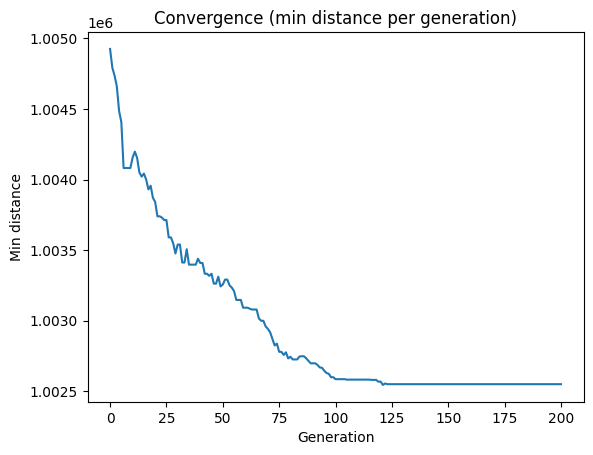

In [29]:
# ---------------------------
# Results
# ---------------------------
best_ind = hof[0]
best_route_customer_ids = [idx_to_cust[i] for i in best_ind]
best_distance = evalVRP_indexed(best_ind)[0]

print("Best route (customer IDs):", best_route_customer_ids)
print("Best distance:", best_distance)

gen = log.select("gen")
mins = log.select("min")
plt.plot(gen, mins)
plt.xlabel("Generation")
plt.ylabel("Min distance")
plt.title("Convergence (min distance per generation)")
plt.show()
